# Python libraries

In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
import glob
import shutil
import cv2

import numpy as np
import pandas as pd
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

I will prescribe a function for image visualization in advance.

In [6]:
def plot_image(image_array):
    fig, axes = plt.subplots(1, 5, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(image_array, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Upload it to the flower_photos.tgz archive so that you can stay in these photos

You can use other download methods via:

- **import tarfile**
```python 
import tarfile
import os

flowers_path = r"C:\Users\Name\flower_photos.tgz"
extract_path = r"C:\Users\Name\flower_photos"

with tarfile.open(flowers_path, "r:gz") as tar:
    tar.extractall(path = extract_path)

print("The archive is unpacked in:", extract_path)
```
- **tf.keras.utils.get_file is not an archive format**
```python
import tensorflow as tf

flowers_path = r"C:\Users\Name\flower_photos.tgz"
base_dir = tf.keras.utils.get_file(fname = "flower_photos",
                                   origin = "file://" + flowers_path.replace("\\", "/"),
                                   untar = True,
                                   archive_format = "tar")
print("Files in:", base_dir)
```
- **tf.data.A set of data.list_files("C:/Users/Name/flower_photos /*/*")**
```python
import tensorflow as tf

files = tf.data.Dataset.list_files("C:/Users/Name/flower_photos/*/*")
for f in files.take(5):
    print(f.numpy())
```
- **tf.keras.preprocessing.image_dataset_from_directory**
```python
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = "C:/Users/Name/flower_photos",
                                                               labels = "inferred",
                                                               label_mode = "int",
                                                               image_size = (XXX, XXX),
                                                               batch_size = 32)

for images, labels in train_ds.take(1):
    print(images.shape, labels.numpy())
```
The easiest way in Windows: Request 1 (tarfile) or request 2 (get_file - archive format = "tar")

In [7]:
flowers_path = pathlib.Path(r"C:\Users\Nikita\flower_photos.tgz")
file_url = flowers_path.as_uri()
base_dir = tf.keras.utils.get_file(fname = "flower_photos",
                                   origin = file_url,
                                   untar = True)

print("Files in:", base_dir)

Files in: C:\Users\Nikita\.keras\datasets\flower_photos


Let's separate our class labels into a separate array for further work.

In [8]:
target = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Let's divide our (names) files into train and valid selections through the built-in os functions

In [11]:
for i in target:
    img_dir = os.path.join(base_dir, i)
    # image = [daisy_1.jpg, daisy_2.jpg, daisy_3.jpg, ...] for i = daisy (only one target from img_dir)
    image = glob.glob(img_dir + "/*.jpg")
    print("{}: {} images".format(i, len(image)))
    train, val = image[:round(len(image)*0.8)], image[round(len(image)*0.8):]

    # Create the train folder inside base_dir and move the file names from the train variable
    for j in train:
        if not os.path.exists(os.path.join(base_dir, 'train', i)):
            os.makedirs(os.path.join(base_dir, "train", i))
        shutil.copy(j, os.path.join(base_dir, "train", i))

    # Create the val folder inside base_dir and move the file names from the val variable
    for k in val:
        if not os.path.exists(os.path.join(base_dir, 'val', i)):
            os.makedirs(os.path.join(base_dir, "val", i))
        shutil.copy(k, os.path.join(base_dir, "val", i))

daisy: 633 images
dandelion: 898 images
roses: 641 images
sunflowers: 699 images
tulips: 799 images


Let's check the correctness of the file paths

In [12]:
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")

In [13]:
train_dir, val_dir

('C:\\Users\\Nikita\\.keras\\datasets\\flower_photos\\train',
 'C:\\Users\\Nikita\\.keras\\datasets\\flower_photos\\val')

# Automatic augmentation via ImageDataGenerator

**Image augmentation** is the artificial increase and diversity of a training dataset by applying random transformations to the source images.

**What are augmentations?**
- Geometric: rotations, shifts, reflections, scaling, drops.
- Photometric: changing brightness, contrast, saturation, adding noise.
- Spatial: elastic deformations, random cuts, mixup, cutmix.

**Why augmentation is needed**
- Fight against overfitting → the model does not memorize specific pictures, but learns to be resistant to variations.
- Magnification of data → is especially important if the dataset is small (for example, 1000 images instead of 100,000).
- Imitation of real conditions → in real life, an object can be taken from different angles, under different lighting conditions.
- Improving generalizing ability → the network learns to better identify features that are really important for classification.

One of the most popular and simple augmentation techniques is the **ImageDataGenerator** class.

ImageDataGenerator is a class that:
- Loads images in batches (by folders or from arrays).
- **Automatically** applies random transformations (augmentations) "on the fly" — that is, the network sees slightly modified images every epoch.
- Can scale, normalize and center data.


**When is it useful to use it?**
- When you have little data
- In geophysics or medicine, samples are often limited. ImageDataGenerator helps to increase the diversity of data through augmentation, which reduces overfitting.
- To speed up learning without saving new files. He applies augmentation on the fly, right in the learning process. It saves disk space and there are no duplicate images.
- For data standardization
- It is convenient to immediately embed normalization (for example, rescale=1./255). All images will be reduced to the same size and range of values.
- When it is convenient to work with a catalog in the format:
```python
dataset/
    class1/
        img001.jpg
        img002.jpg
    class2/
        img101.jpg
        img102.jpg
```
Then you can just write:
```python
train_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 30, zoom_range = 0.2)
train_ds  = train_gen.flow_from_directory("dataset/train", target_size = (150, 150), batch_size = 32)
```
- For rapid prototyping. If you need to quickly run the model and test the hypothesis. You don't have to write your own generator, you can use a ready-made ImageDataGenerator.

Pay attention to the image_shape, since (150, 150) is used when building the model, and here we set 150

In [14]:
batch_size = 64
image_shape = 150

train_image_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
train_data_gen = train_image_gen.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (image_shape, image_shape))

Found 2935 images belonging to 5 classes.


Let's build 5 augmented images

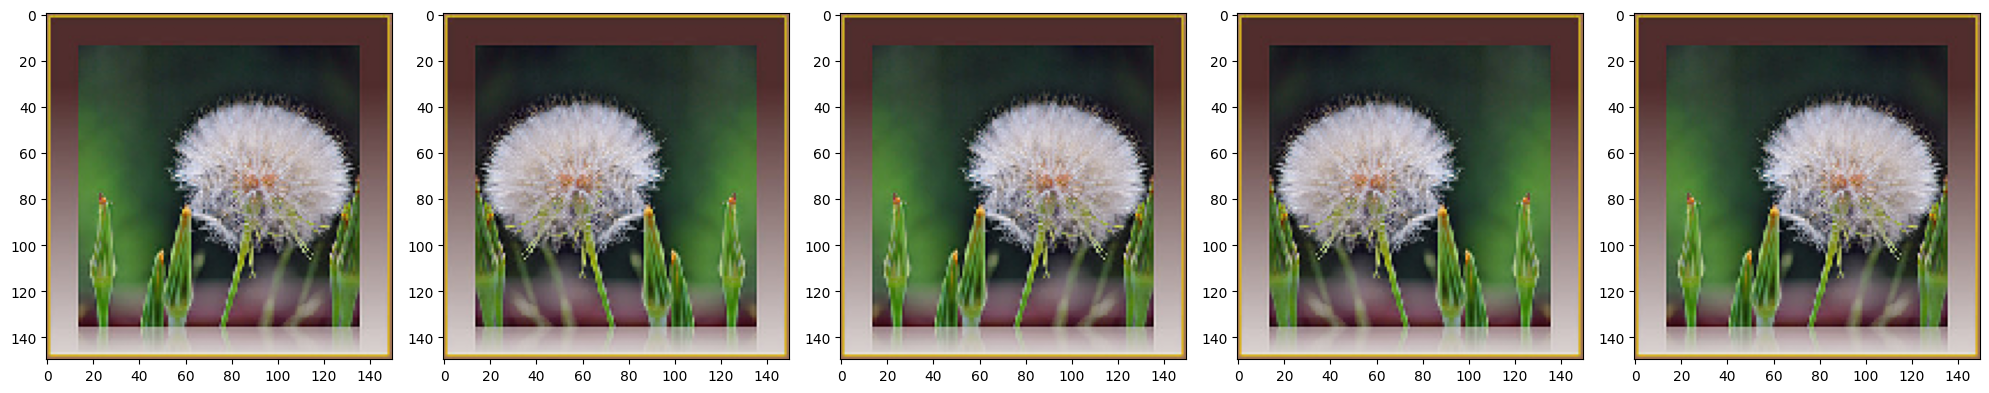

In [15]:
augmented_image = [train_data_gen[0][0][0] for i in range(5)]
plot_image(augmented_image)

There are a lot of parameters in the ImageDataGenerator function, you can find them on the official website of the tensorflow library.

Found 2935 images belonging to 5 classes.


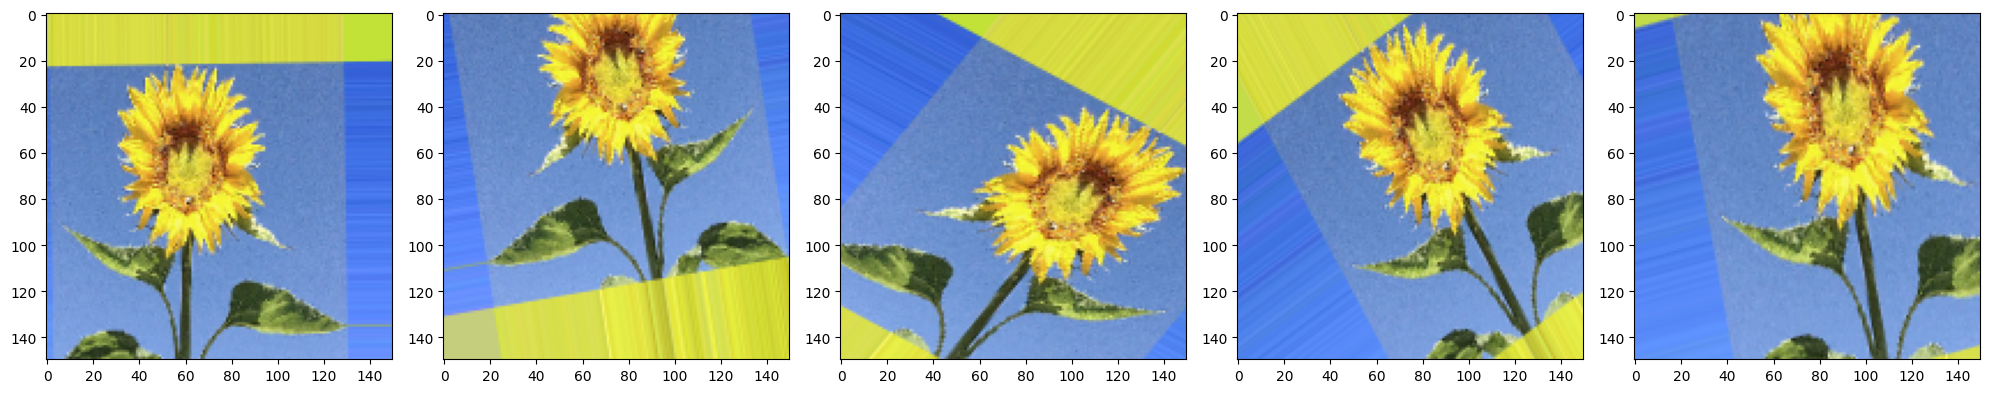

In [16]:
train_image_gen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
train_data_gen = train_image_gen.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (image_shape, image_shape),
                                                     class_mode = 'sparse')
train_augmented_image = [train_data_gen[0][0][0] for i in range(5)]
plot_image(train_augmented_image)

Found 735 images belonging to 5 classes.


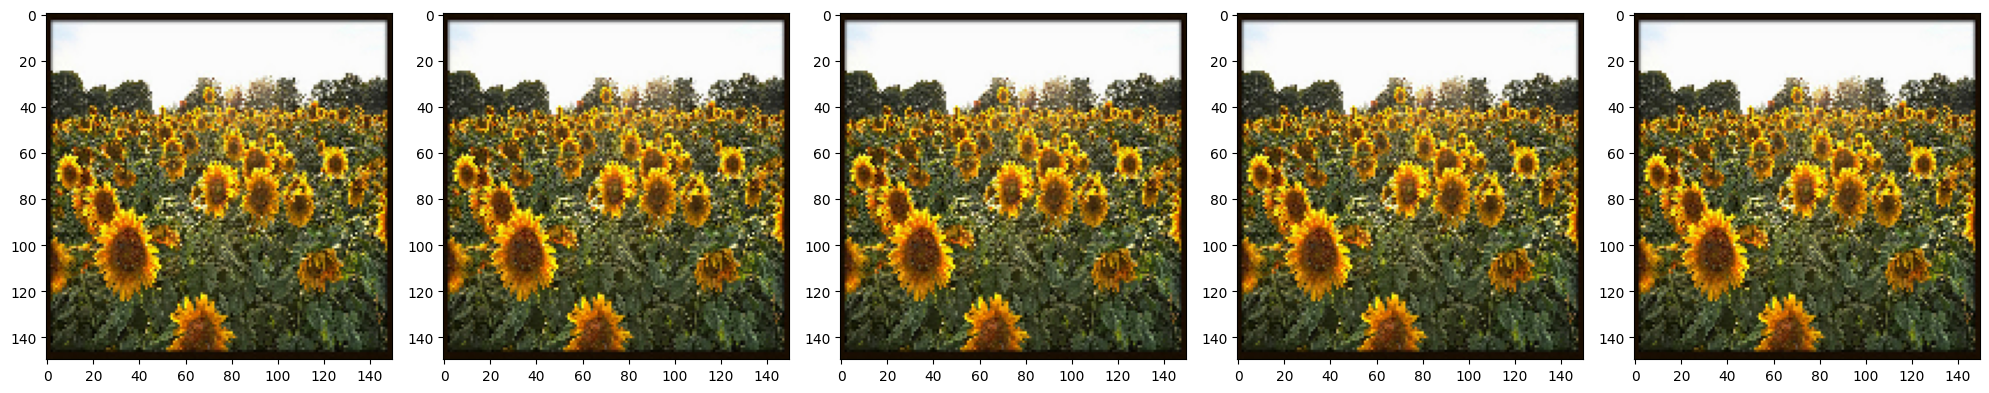

In [17]:
val_image_gen = ImageDataGenerator(rescale=1./255)
val_data_gen  = val_image_gen.flow_from_directory(batch_size = batch_size,
                                                  directory = val_dir,
                                                  target_size = (image_shape, image_shape),
                                                  class_mode = 'sparse')
val_augmented_image = [val_data_gen[0][0][0] for i in range(5)]
plot_image(val_augmented_image)

# Сustom generator via tf.keras.utils.Sequence with manual augmentation and training with batch data transmission. 

The CustomDataGenerator() class has a raw look, you can supplement it for your own purposes and objectives.

The CustomDataGenerator() class uses the Sequence protocol, let's talk about it in more detail.

**Sequence is a** basic protocol class for Python batch generators that Keras can safely and efficiently use in model.fit() /evaluate() /predict():
— provides thread safety and deterministic sampling order;
- works correctly with parallel loading (workers>1, use_multiprocessing = True);
- ensures that the same sample is not queued twice during multiprocessing.

**Why use Sequence instead of "just a generator"?**
- Regular Python generators (or __iter__) do not provide guarantees of order and can "feed" the same batch twice during multiprocessing. Sequence solves this because Keras accesses index files via __getitem__(index) and knows the full length via __len__().

**What needs to be implemented (minimum)?**
- __len__(self) -> int
- The number of batches per epoch. Most often, ceil(N /batch_size) or N // batch_size, if you want to "cut off the tail".
- __getitem__(self, index). Returns a single batch: (x, y) or (x, y, sample_weight). Important: return numpy arrays or tensors of stable shape and dtypes.
- (optional) on_epoch_end(self). Keras is called after each epoch. It is convenient for shuffling indexes and resetting states.

**How does it work inside fit()?**
- Keras requests len(seq) → knows steps_per_epoch.
- Calls seq[i] at each iteration.
- With workers>1 and use_multiprocessing=True, several processes pull different i's in parallel, but Sequence ensures that the patches are not mixed up.

**What can I return from __getitem__?**
- Classification: (x_batch, y_batch) (where y_batch are int labels or one-hot).
- Sample weights: (x_batch, y_batch, sample_weight_batch).
- Multi-output models: ({'in1': x1, 'in2': x2}, {'out1': y1, 'out2': y2})

**When do I need a Custom Generator?**
- Non-standard data: images + masks (segmentation) → you need to upload a pair of picture+mask.
- Multiple inputs (for example, satellite image + DEM map).
- Different data formats (JPEG + .npy + CSV).
- Using libraries like Albumentations or imgaug (stronger and more flexible than ImageDataGenerator).
- Specific transformations for the task.
- Batch control: stratification of classes within a batch (for example, so that there is always a balance). Batch generation according to certain rules (time series, patch-based training).
- Mixing multiple datasets with different weights. With very large datasets, it is convenient to manage reading (for example, store only file paths and upload on the fly). You can embed caching, preloading, and parallel processing.
- Train/valid indexes can be explicitly passed to Sequence. ImageDataGenerator does not provide such control.

Again, pay attention to the image_shape

In [18]:
image_shape = (150, 150)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, image_shape, augment = True, crossvalid_index = None, shuffle = None):
        self.directory = directory
        self.shuffle = shuffle
        
        self.image_shape = image_shape
        self.batch_size = batch_size
        
        self.target = sorted([d for d in os.listdir(directory) 
                        if os.path.isdir(os.path.join(directory, d))])    # The names of the targets folders from directory
        self.target_index = {i: idx for idx, i in enumerate(self.target)} # Dictionary target index {Target: number}
        
        self.augment = augment                                            # Augmentation
        
        self.image_path = []                                              # Array for image file names
        self.labels = []                                                  # Array of class labels

                                                                          # A loop for extracting an array of image file names and class labels
        for i in self.target:
            target_dir = os.path.join(directory, i)
            for j in os.listdir(target_dir):
                if j.endswith((".jpg", ".png", ".jpeg")):
                    full_path = os.path.join(target_dir, j)              # Adding the full path
                    self.image_path.append(full_path)
                    self.labels.append(self.target_index[i])

        self.image_path = np.array(self.image_path)
        self.labels = np.array(self.labels)

        if crossvalid_index is None:                                    # This condition is prescribed for allocating idx_train and idx_valid cross-validation in order to get file paths by indexes.
            self.image_path = self.image_path
            self.labels =  self.labels
        else:
            self.image_path = self.image_path[crossvalid_index]
            self.labels = self.labels[crossvalid_index]

        self.image_index = np.arange(len(self.image_path))               # Image Indexes
        np.random.shuffle(self.image_index)                              # We mix these indexes

        # We check that the images have been uploaded
        print(f"Uploaded {len(self.image_path)} images from the {directory} directory")

    def __len__(self):
        return int(np.ceil(len(self.image_path) / self.batch_size))

    def __getitem__(self, index):
                                                                         # The butch index
        batch_index = self.image_index[index * self.batch_size : min((index + 1) * self.batch_size, len(self.image_path))]
        
        batch_images = []                                                # The name of the images in the batch
        batch_labels = []                                                # The name of the class labels in the batch

        for i in batch_index:
            img = cv2.imread(self.image_path[i])                         # Reading the picture through the path
            # We check that the image is uploaded correctly.
            if img is None:
                print(f"Image loading error: {self.image_path[i]}")
                img = np.zeros((self.image_shape[1], self.image_shape[0], 3), dtype = np.uint8) # Creating a black image instead of a pass is a test
            else:
                #print(f"Image uploaded: {self.image_path[i]}")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                # Converting from BGR to RGB

            # Changing the size
            img = cv2.resize(img, self.image_shape)

            if self.augment:
                img = self.augment_image(img)                            # The function is described below

            img = img.astype(np.float32) / 255                           # Normalization of pixels to the range [0, 1]!

            batch_images.append(img)                                     # Adding the image to the batch
            batch_labels.append(self.labels[i])                          # Adding a label to the batch

        return np.array(batch_images), np.array(batch_labels)            # Converting lists to numpy arrays

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_index)

    def augment_image(self, img):
                                                                         # 1. Rotation (-40 to 40 degrees)
        if random.random() > 0.5:
            angle = random.uniform(-40, 40)
            h, w = img.shape[:2]
            center = (w // 2, h // 2)
            matrix_rotate = cv2.getRotationMatrix2D(center, angle, 1.0) # Creating a rotation matrix
            img = cv2.warpAffine(img, matrix_rotate, (w, h), borderMode = cv2.BORDER_REFLECT) # We apply the affine transformation

        if random.random() > 0.5:                                       # 2. Horizontal and vertical shift (up to 20%)
            tx = random.uniform(-0.2, 0.2) * self.image_shape[0]
            ty = random.uniform(-0.2, 0.2) * self.image_shape[1]
            matrix_rotate = np.float64([[1, 0, tx], [0, 1, ty]])
            img = cv2.warpAffine(img, matrix_rotate, self.image_shape, borderMode = cv2.BORDER_REFLECT)

        if random.random() > 0.5:                                       # 3. Zoom change (zoom from 0.8 to 1.2)
            scale = random.uniform(0.8, 1.2)
            h, w = img.shape[:2]
            center = (w // 2, h // 2)
                                                                        # getRotationMatrix2D(transform center, rotation angle, zoom)
            matrix_rotate = cv2.getRotationMatrix2D(center, 0, scale)
                                                                        # warpAffine(Image, Rotation Matrix, Target dimensions, Border mod)
            img = cv2.warpAffine(img, matrix_rotate, (w, h), borderMode = cv2.BORDER_REFLECT)

        if random.random() > 0.5:                                       # 4. Horizontal reflection
            img = cv2.flip(img, 1)

        if random.random() > 0.5:                                       # 5. Changing brightness and contrast
            alpha = random.uniform(0.8, 1.2)                            # Contrast (1.0 - unchanged)
            beta = random.uniform(-20, 20)                              # Brightness (0 - unchanged)
            img = cv2.convertScaleAbs(img, alpha = alpha, beta = beta)

        if random.random() > 0.7 and img.dtype == np.float32:           # 6. Adding noise
            noise = np.random.normal(0, 0.05, img.shape).astype(np.float32)
            img = img + noise
            img = np.clip(img, 0, 1)

        return img

In [19]:
# Creating data generators
train_generator = CustomDataGenerator(directory = train_dir,
                                      batch_size = batch_size,
                                      image_shape = image_shape,  # (150, 150)
                                      augment = True              # Enabling augmentation for training data
                                     )

val_generator = CustomDataGenerator(directory = val_dir,
                                    batch_size = batch_size,
                                    image_shape = image_shape,
                                    augment = False              # Disabling augmentation for validation data
                                   )

# We check that the generators are working correctly.
print(f"The number of batches in the training generator: {len(train_generator)}")
print(f"Number of batches in the validation generator: {len(val_generator)}")
print(f"Number of classes: {len(train_generator.target)}")
print(f"Matching classes: {train_generator.target_index}")

Uploaded 2935 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Uploaded 735 images from the C:\Users\Nikita\.keras\datasets\flower_photos\val directory
The number of batches in the training generator: 46
Number of batches in the validation generator: 12
Number of classes: 5
Matching classes: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


# Checking a constructed class on a null batch

In [20]:
try:
    test_batch = train_generator[0]
    print(f"The first batch was uploaded successfully. The shape of the images: {test_batch[0].shape}")
except Exception as e:
    print(f"Error loading the batch: {e}")
    # Let's check several paths to the images
    print("The first 5 paths to images:")
    for i in range(min(5, len(train_generator.image_path))):
        path = train_generator.image_path[i]
        exists = os.path.exists(path)
        print(f"{path}: exists={exists}")

The first batch was uploaded successfully. The shape of the images: (64, 150, 150, 3)


# Let's build a basic (simplest) neural network for the task of multiclass image classification

The softmax activation function will not return class labels, but probabilities, which we can use argmax to result in labels.

In [21]:
image_shape = 150
model = tf.keras.Sequential([tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (image_shape, image_shape, 3)),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             
                             tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                            
                             tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                            
                             tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation = 'relu'),
                             tf.keras.layers.Dense(len(target), activation = 'softmax')])

model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

# Transfer learning

Let's try to use the tensorflow.keras.applications model for transfer learning.ResNet50(), trained on ImageNet.

The number 50 in the name of ResNet50 is not the number of layers in terms of Keras .layers, but the number of trained weight operations (convolution + FC).

When you look at base_model.layers, it lists all the layers of the model.:
- Conv2D
- BatchNormalization
- Activation
- Add (addition in residual blocks)
- and auxiliary layers (InputLayer, etc.)

Therefore , the total number .The layers in the Keras version of ResNet50 are 175, not 50.

**ResNet50 features:**
- Depth: 50 layers
- Idea: residual blocks (skip connections) that allow us to train very deep networks without fading the gradient
- Basic trend: the first layers teach low-level features (gradients, textures, contours), the middle teaches medium-level features (shapes, patterns), the upper layers teach high-level features (dog, cat, car)

**Which layers should be frozen and which should not be for the ResNet architecture in general:**
- At the beginning (Conv1 + the first residual blocks): These layers teach basic filters (borders, lines, textures). They can be frozen because they are universal for all images.
- In the middle (res3–res4 blocks): These layers begin to learn more specific patterns. It can be partially unfrozen, depending on the size of the dataset.
- At the end (res5 + classifier): These layers teach high-level ImageNet classes (tigers, planes, cars). They are not suitable for this task of classifying color labels, so it is better to replace them and retrain them.

Flowers have repeating patterns (petals, leaves, textures) that ResNet already "knows how" to extract.

We only need to retrain the upper levels so that they do not distinguish between cats and dogs, but rather our classes ("rose", "sunflower", "daisy", etc.).

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

example_model = ResNet50(include_top = True,
                         weights = "imagenet",
                         input_tensor = None,
                         input_shape = None,
                         pooling = None,
                         classes = 1000,
                         classifier_activation = "softmax")
                         #name = "resnet50_v1")

example_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
base_model = ResNet50(include_top = False,
                      weights = "imagenet",
                      input_shape = (image_shape, image_shape, 3))

# Freeze the database
for layer in base_model.layers[:140]:   # first 140 layers (res3d_branch2b)
    layer.trainable = False
for layer in base_model.layers[140:]:   # rest are unfrozen
    layer.trainable = True

# adding a head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(target), activation = "softmax")(x)

model = models.Model(inputs = base_model.input, outputs = output)

model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# 1 method. Training based on all train/valid data

This method often leads to retraining. I'm just presenting the simplest example.

In [23]:
def plot_loss(epochs, history_one):
    epochs_range = range(epochs)
    
    acc = history_one.history['accuracy']
    loss = history_one.history['loss']
    val_acc = history_one.history['val_accuracy']
    val_loss = history_one.history['val_loss']
    
    plt.figure(figsize = (12, 5))
    
    # ---- Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss,     label='Train Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Valid Loss', color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss on train/valid samples")

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc,     label='Train Acc', color='green')
    plt.plot(epochs_range, val_acc, label='Valid Acc', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy on train/valid samples")

    plt.tight_layout()
    plt.show()

Since there is a lot of data (>3000 photos), we will use some techniques to reduce the learning time and reduce retraining.

**EarlyStopping, ReduceLROnPlateau and ModelCheckpoint to reduce model overfitting**

**EarlyStopping:**
- What it does: monitors the val_loss metric. If it stops improving for a certain number of epochs (patience), learning stops automatically.
- Why it's useful: it prevents overfitting and saves time. The model will not "suffer" for another 20 epochs if the quality is not already increasing.
- Useful feature: you can enable restore_best_weights = True, then the weights from the best epoch will return.

**ReduceLROnPlateau:**
- What is he doing: reduces the learning rate (learning step) if the metric (for example, val_loss) is "stuck" and does not improve.
- Why it's useful: sometimes a model learns well at the beginning, but then can't take the next step because the learning rate is too high. Lowering allows you to get out of the "plateau" and continue improving.
A useful feature: the factor parameter sets how many times to reduce lr, and min_lr is the minimum limit.

**ModelCheckpoint:**
- What it does: saves the weights of the model after each epoch. You can save only the best (save_best_only = True) by the selected metric (monitor = 'val_loss').
- Why it's useful: if the training went wrong or the model retrained, you still have a file with the best weights.
- Useful feature: it is convenient to combine with EarlyStopping → even if the training has stopped, the weights will be saved automatically.

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(monitor = "val_loss",          # we monitor the loss function on
                           patience = 20,                 # the "rounds" validation — if there are 20 epochs without improvements → stop
                           restore_best_weights = True    # restoring weights from the best epoch
                          )

reduce_lr = ReduceLROnPlateau(monitor = "val_loss",       # we monitor the validation loss function
                              factor = 0.1,               # how many times to reduce lr (0.2 → 5 times)
                              patience = 20,              # how many epochs to wait before reducing
                              min_lr = 1e-4               # the lower limit of the lr
                             )

checkpoint = ModelCheckpoint("best_resnet50_v1.h5",       # file to save
                             monitor = "val_loss",
                             save_best_only = True,
                             mode = "min"
                            )

Epochs = 100

# For custom generator (overfitting)
'''
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator),  # Number of batches per epoch
                    epochs = Epochs,
                    validation_data = val_generator,
                    validation_steps = len(val_generator),   # Number of batches for validation
                    verbose = 1,
                    callbacks = [early_stop, reduce_lr, checkpoint]
                   )
''';

# For automatically generator
train_image_gen = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

train_data_gen = train_image_gen.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (image_shape, image_shape),
                                                     class_mode = 'sparse')

val_image_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen  = val_image_gen.flow_from_directory(batch_size = batch_size,
                                                  directory = val_dir,
                                                  target_size = (image_shape, image_shape),
                                                  class_mode = 'sparse')

history = model.fit_generator(train_data_gen,
                              steps_per_epoch = int(np.ceil(train_data_gen.samples / float(batch_size))),
                              epochs = Epochs,
                              validation_data = val_data_gen,
                              validation_steps = int(np.ceil(val_data_gen.samples / float(batch_size))),
                              callbacks = [early_stop, reduce_lr, checkpoint])

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.
Epoch 1/100
46/46 [==============================] - 28s 522ms/step - loss: 0.2978 - accuracy: 0.8886 - val_loss: 1.0179 - val_accuracy: 0.6639 - lr: 1.0000e-04
Epoch 2/100
46/46 [==============================] - 23s 497ms/step - loss: 0.2510 - accuracy: 0.9077 - val_loss: 1.0718 - val_accuracy: 0.6694 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - 23s 505ms/step - loss: 0.2204 - accuracy: 0.9172 - val_loss: 0.5126 - val_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - 22s 472ms/step - loss: 0.2210 - accuracy: 0.9210 - val_loss: 0.8088 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 5/100
46/46 [==============================] - 22s 481ms/step - loss: 0.1949 - accuracy: 0.9261 - val_loss: 0.6344 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 6/100
46/46 [==============================] - 22s 478ms/step - loss: 0.1958 - accuracy: 0.9274 - val_loss

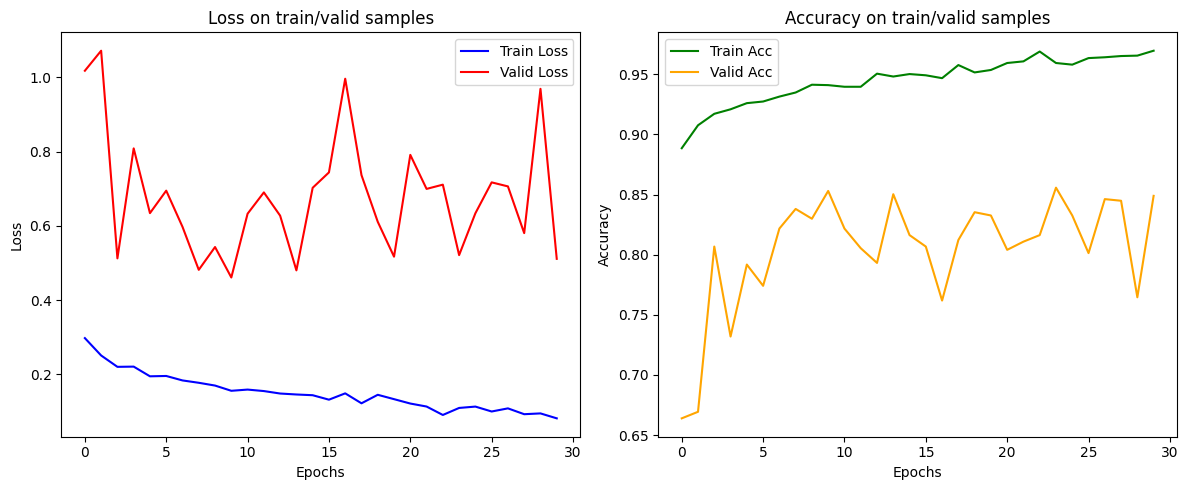

In [44]:
# ImageDatagenerator
plot_loss(history.epoch[-1] + 1, history)

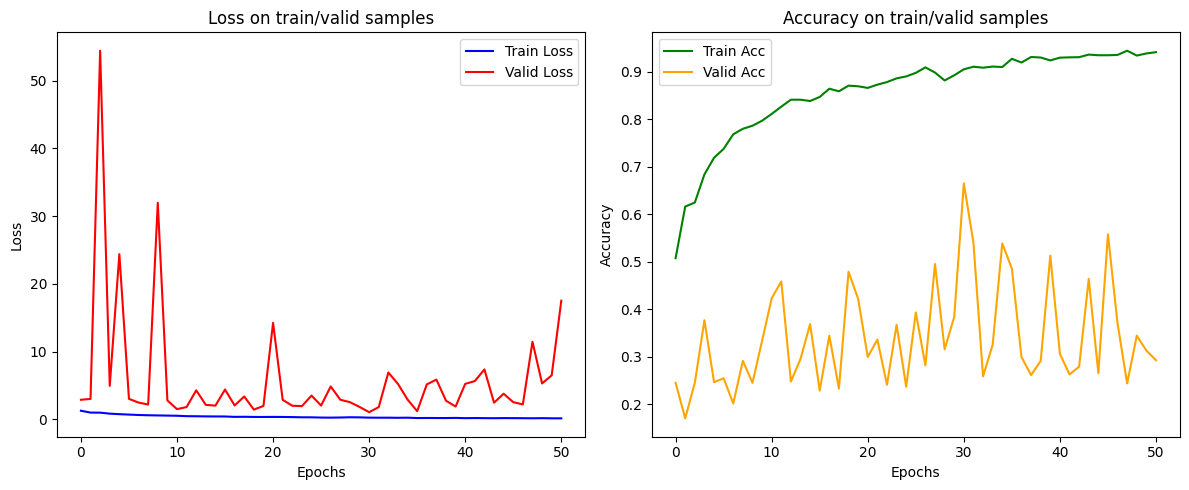

In [42]:
# transfer learning - ResNet50 - with callbacks (!overfitting, the model is not suitable for this data generator)
plot_loss(history.epoch[-1] + 1, history)

There is over-refinement when both algorithms work, but it can be reduced in the case of ImageDataGenerator. The architecture of ResNet50 is very complex, you can start training your head not from 143 layers, but from 160, 170, try adding additional Conv2D layers with normalization, try adding other transformations to the protocol, etc..

# 2 method. Learning through cross-validation for Custom Generator.

One of the most stable ways.

If we just divide the data by train/valid (say, 80/20), we get one quality score.

But:
- the selection may be heterogeneous (one section has more simple images, the other has more complex ones);
- classes may be unbalanced (for example, "daisy" 1000 pictures, "tulip" 300);
- the model can be retrained based on specific train data.

Bottom line: we get an estimate that strongly depends on how "lucky" we are with the split.

KFold was used due to the lack of imbalance in classes.

There are many other methods, such as GroupKFold, which will predict the label from images of one class, then move on to another, and so on. For more information, visit the sklearn library website.

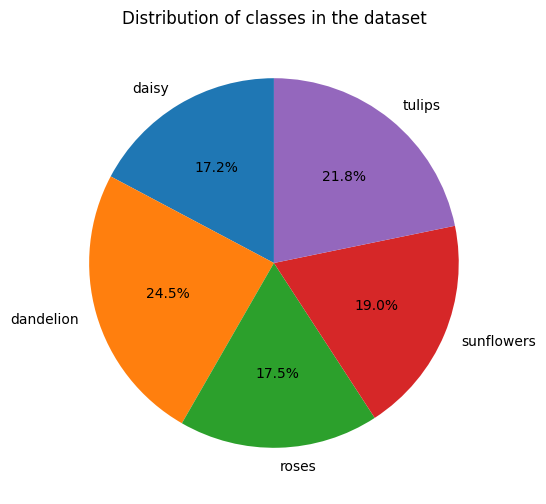

In [45]:
y = np.array(train_generator.labels)
unique, counts = np.unique(y, return_counts = True)
percentages = counts / counts.sum() * 100
class_names = list(train_generator.target_index.keys())

plt.figure(figsize=(6,6))
plt.pie(percentages, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of classes in the dataset")
plt.show()

Uploaded 2348 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Uploaded 587 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Fold - №1...


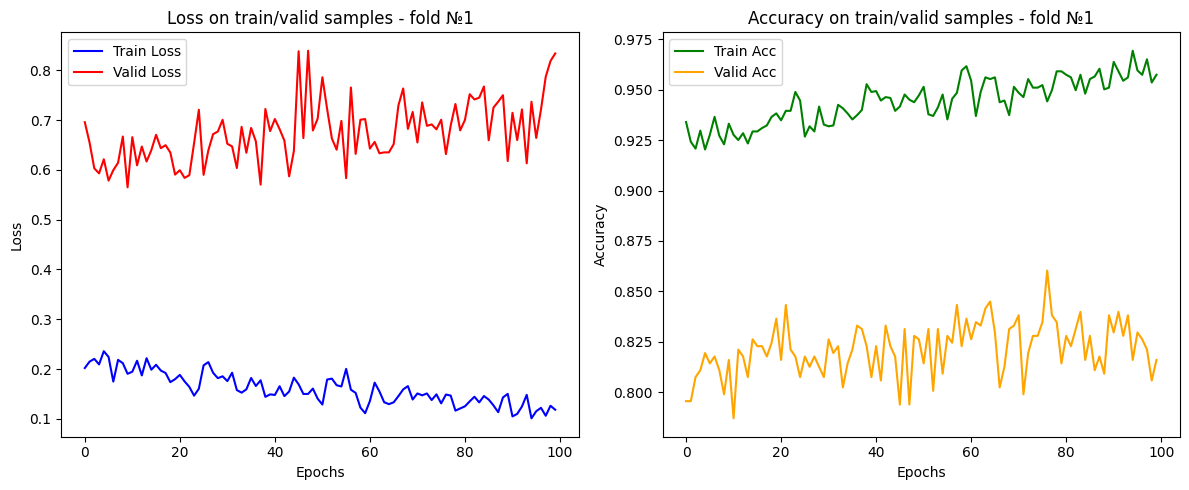

Accuracy fold 1: 0.8160
Uploaded 2348 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Uploaded 587 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Fold - №2...


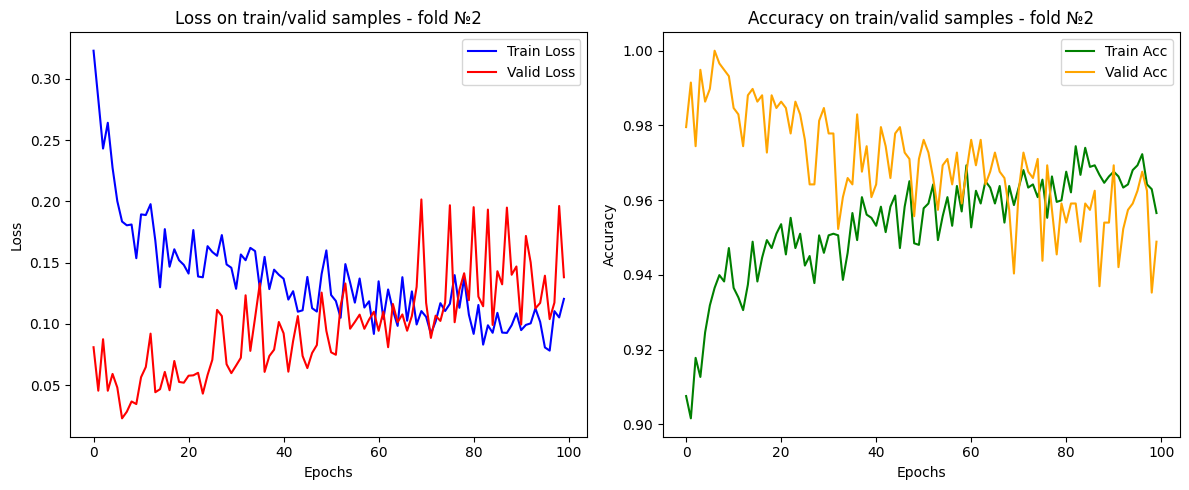

Accuracy fold 2: 0.9489
Uploaded 2348 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Uploaded 587 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Fold - №3...


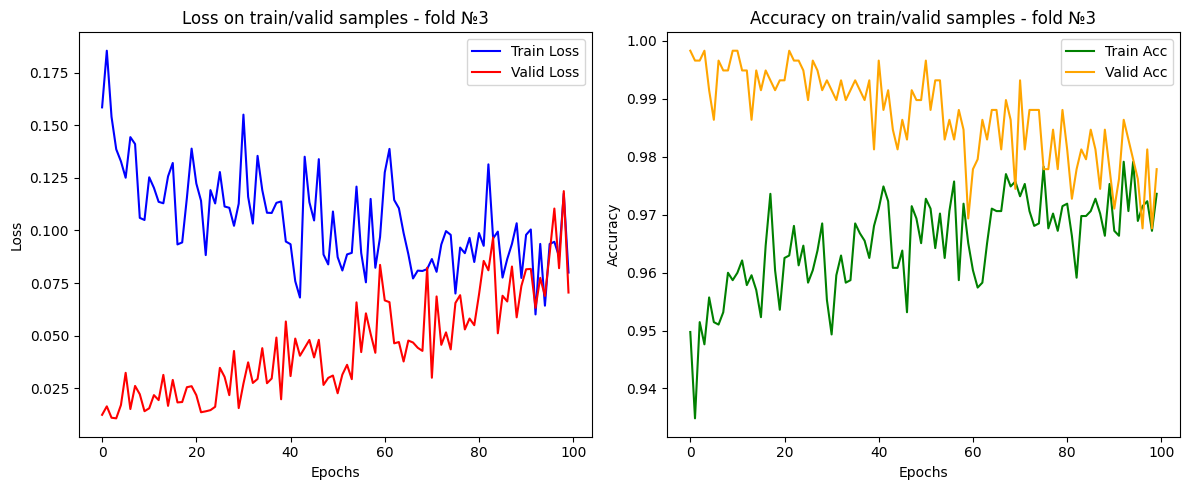

Accuracy fold 3: 0.9779
Uploaded 2348 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Uploaded 587 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Fold - №4...


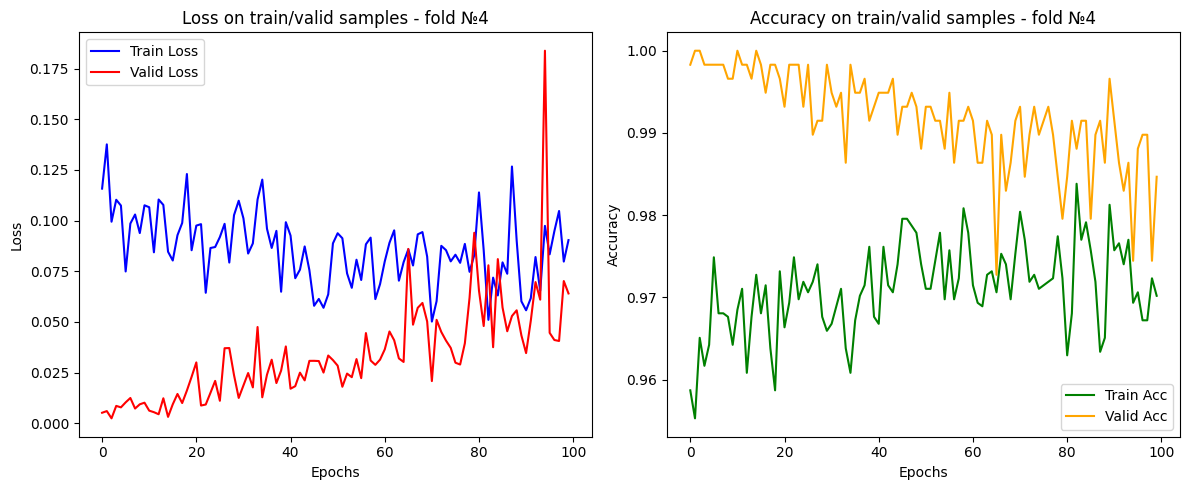

Accuracy fold 4: 0.9847
Uploaded 2348 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Uploaded 587 images from the C:\Users\Nikita\.keras\datasets\flower_photos\train directory
Fold - №5...


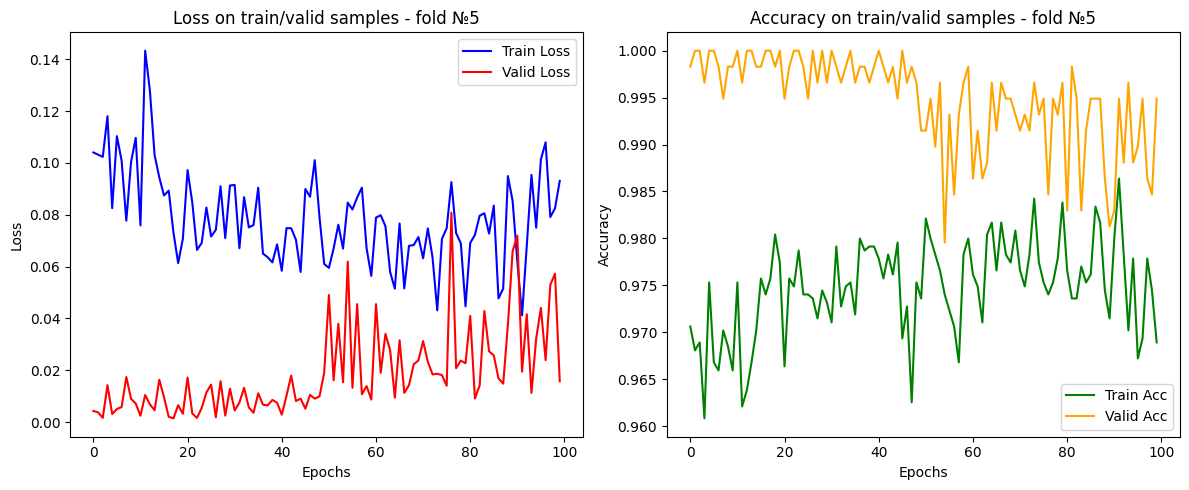

Accuracy fold 5: 0.9949

Average accuracy by folds: 0.94
Accuracy for all predictions (aggregated): 0.94


In [134]:
# For Custom Geneartor !!!
# Val generator for "test" prediction
X = np.array(train_generator.image_path)                                        # file paths
y = np.array(train_generator.labels)                                            # numeric class labels

Epochs = 100
batch_size = 64
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
# for storing predictions and labels
all_y_true = []
all_y_pred = []
fold_accuracies = []

def plot_loss(epochs, fold_number, fold_history):
    epochs_range = range(epochs)
    
    acc = fold_history.history['accuracy']
    loss = fold_history.history['loss']
    val_acc = fold_history.history['val_accuracy']
    val_loss = fold_history.history['val_loss']
    
    plt.figure(figsize = (12, 5))
    
    # ---- Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss,     label='Train Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Valid Loss', color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss on train/valid samples - fold №{fold_number + 1}")

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc,     label='Train Acc', color='green')
    plt.plot(epochs_range, val_acc, label='Valid Acc', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy on train/valid samples - fold №{fold_number + 1}")

    plt.tight_layout()
    plt.show()

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
    
    train_gen = CustomDataGenerator(directory = train_dir,
                                    batch_size = batch_size,
                                    image_shape = (150, 150),
                                    augment = True,
                                    crossvalid_index = idx_train,
                                    shuffle = True)

    valid_gen = CustomDataGenerator(directory = train_dir,
                                    batch_size = batch_size,
                                    image_shape = (150, 150),
                                    augment = False,
                                    crossvalid_index = idx_valid,
                                    shuffle = False)

    print(f"Fold - №{fold + 1}...")

    history = model.fit(train_gen,
                        steps_per_epoch = len(train_gen),  # The number of battles per epoch per fold
                        epochs = Epochs,
                        validation_data = valid_gen,
                        validation_steps = len(valid_gen),   # The number of batches to be validated on one fold
                        verbose = 0
                       )

    plot_loss(Epochs, fold, history)

    y_prob = model.predict(valid_gen, verbose = 0)  # the probabilities
    y_pred = np.argmax(y_prob, axis = 1)            # model label
    y_true = []
    for _, batch_y in valid_gen:
        y_true.extend(batch_y)
    y_true = np.array(y_true)                       # real labels for this fold

    # Saving it for the final metric
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    # Accuracy for the current fold
    acc = accuracy_score(y_true, y_pred)
    fold_accuracies.append(acc)
    print(f"Accuracy fold {fold+1}: {acc:.4f}")

# ---------- SUMMARY METRICS ----------
overall_acc = accuracy_score(all_y_true, all_y_pred)
print("\n============================")
print(f"Average accuracy by folds: {np.mean(fold_accuracies):.2f}")
print(f"Accuracy for all predictions (aggregated): {overall_acc:.2f}")

# 2 method. Learning through cross-validation for ImageDataGenerator.

Now we will write a similar class for the ImageDataGenerator protocol. To do this, remove the augmentation function and its link in __ getitem __, and also do a check on the null batch.

In [46]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, image_shape, augment = True, crossvalid_index = None, shuffle = True):
        self.directory = directory
        self.shuffle = shuffle
        self.image_shape = image_shape
        self.batch_size = batch_size

        self.target = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
        self.target_index = {i: idx for idx, i in enumerate(self.target)}

        self.image_path = []
        self.labels = []

        for i in self.target:
            target_dir = os.path.join(directory, i)
            for j in os.listdir(target_dir):
                if j.endswith((".jpg", ".png", ".jpeg")):
                    full_path = os.path.join(target_dir, j)
                    self.image_path.append(full_path)
                    self.labels.append(self.target_index[i])

        self.image_path = np.array(self.image_path)
        self.labels = np.array(self.labels)

        if crossvalid_index is not None:
            self.image_path = self.image_path[crossvalid_index]
            self.labels = self.labels[crossvalid_index]

        self.image_index = np.arange(len(self.image_path))
        if self.shuffle:
            np.random.shuffle(self.image_index)

        if augment:
            self.datagen = ImageDataGenerator(rotation_range=40,
                                              width_shift_range=0.2,
                                              height_shift_range=0.2,
                                              zoom_range=0.2,
                                              horizontal_flip=True,
                                              brightness_range=[0.8, 1.2],
                                              fill_mode="reflect",
                                              rescale=1./255)
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)

        print(f"Uploaded {len(self.image_path)} images from {directory}")

    def __len__(self):
        return int(np.ceil(len(self.image_path) / self.batch_size))

    def __getitem__(self, index):
        batch_index = self.image_index[index * self.batch_size : (index + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_index:
            img = cv2.imread(self.image_path[i])
            if img is None:
                print(f"Error loading: {self.image_path[i]}")
                img = np.zeros((self.image_shape[1], self.image_shape[0], 3), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_shape)
            batch_images.append(img)
            batch_labels.append(self.labels[i])

        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        batch_images = next(self.datagen.flow(batch_images, batch_size=self.batch_size, shuffle = False))

        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_index)

In [47]:
# Creating data generators
train_generator = CustomDataGenerator(directory = train_dir,
                                      batch_size = batch_size,
                                      image_shape = image_shape,  # (150, 150)
                                      augment = True              # Enabling augmentation for training data
                                     )

val_generator = CustomDataGenerator(directory = val_dir,
                                    batch_size = batch_size,
                                    image_shape = image_shape,
                                    augment = False              # Disabling augmentation for validation data
                                   )

# We check that the generators are working correctly.
print(f"The number of batches in the training generator: {len(train_generator)}")
print(f"Number of batches in the validation generator: {len(val_generator)}")
print(f"Number of classes: {len(train_generator.target)}")
print(f"Matching classes: {train_generator.target_index}")

Uploaded 2935 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Uploaded 735 images from C:\Users\Nikita\.keras\datasets\flower_photos\val
The number of batches in the training generator: 46
Number of batches in the validation generator: 12
Number of classes: 5
Matching classes: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


Uploaded 2348 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Uploaded 587 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Fold - №1...


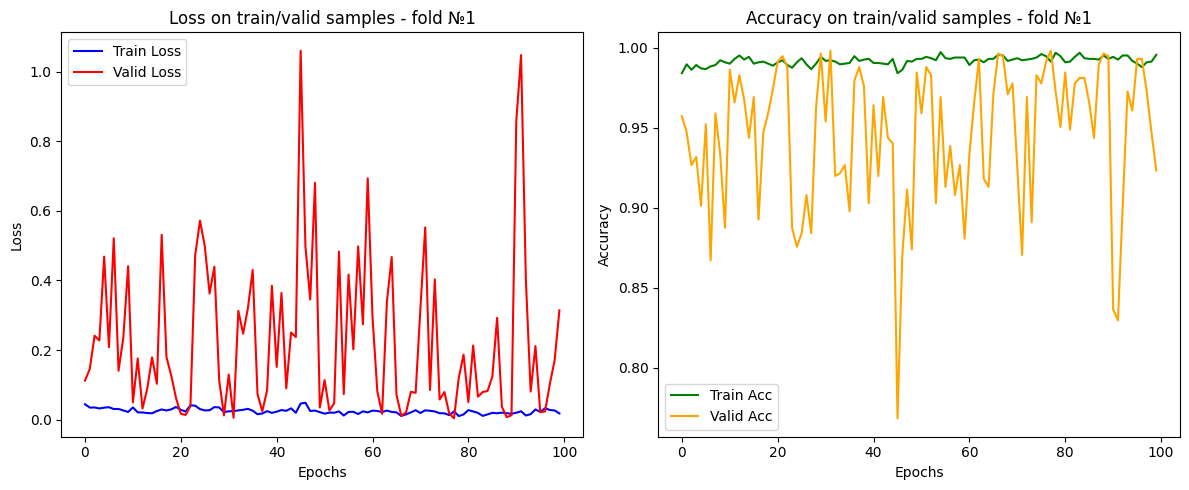

Accuracy fold 1: 0.8790
Uploaded 2348 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Uploaded 587 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Fold - №2...


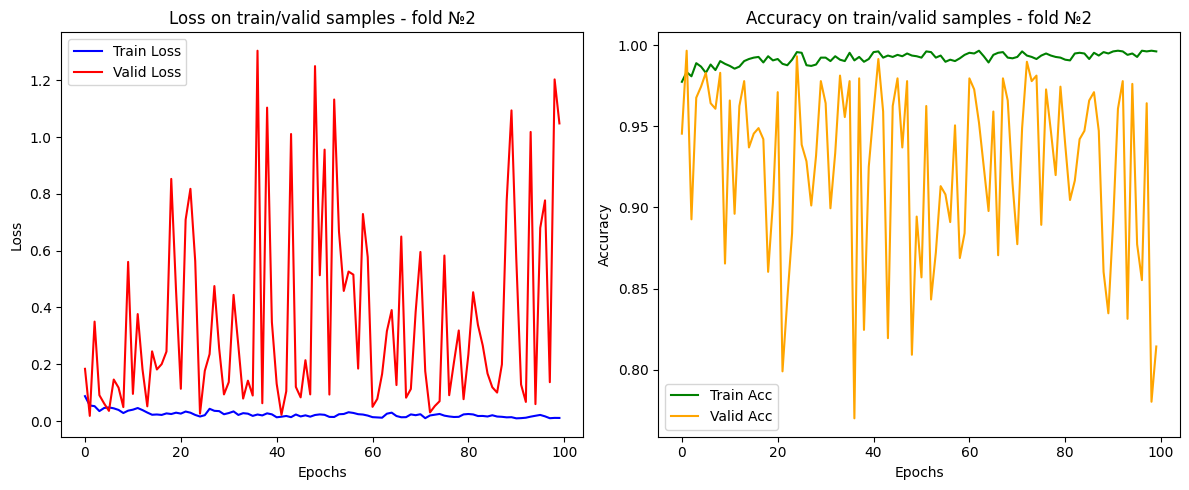

Accuracy fold 2: 0.8143
Uploaded 2348 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Uploaded 587 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Fold - №3...


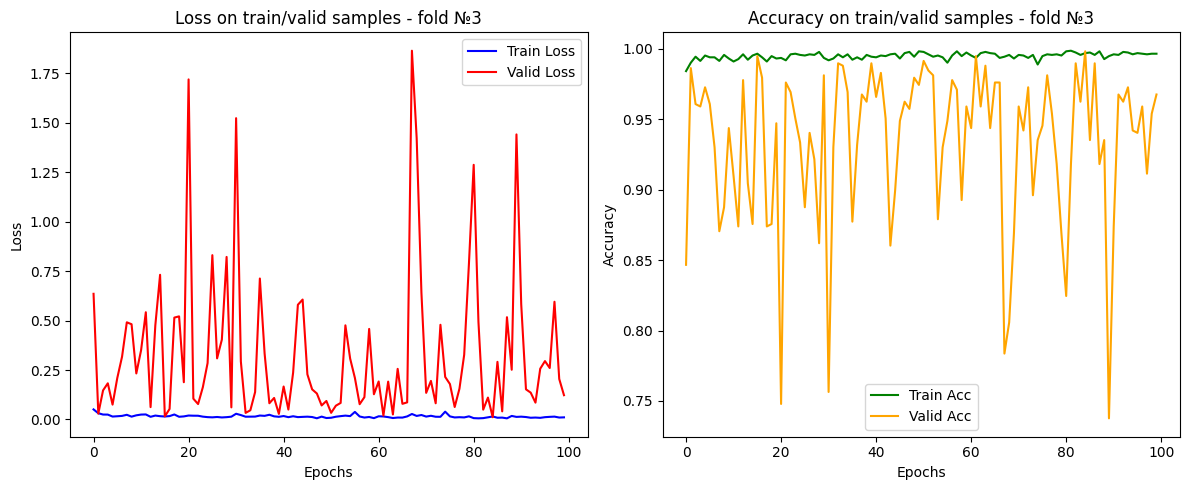

Accuracy fold 3: 0.9676
Uploaded 2348 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Uploaded 587 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Fold - №4...


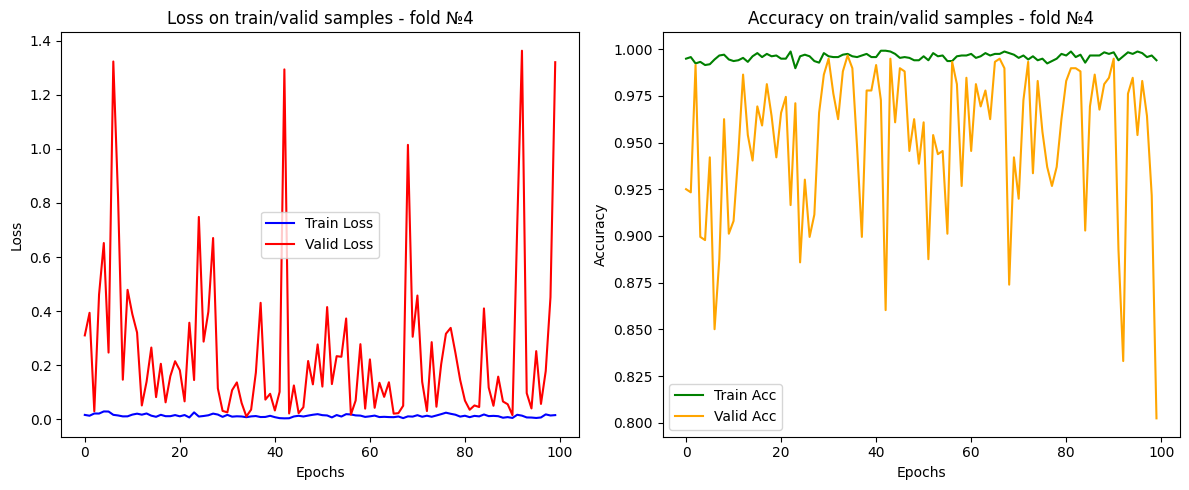

Accuracy fold 4: 0.8024
Uploaded 2348 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Uploaded 587 images from C:\Users\Nikita\.keras\datasets\flower_photos\train
Fold - №5...


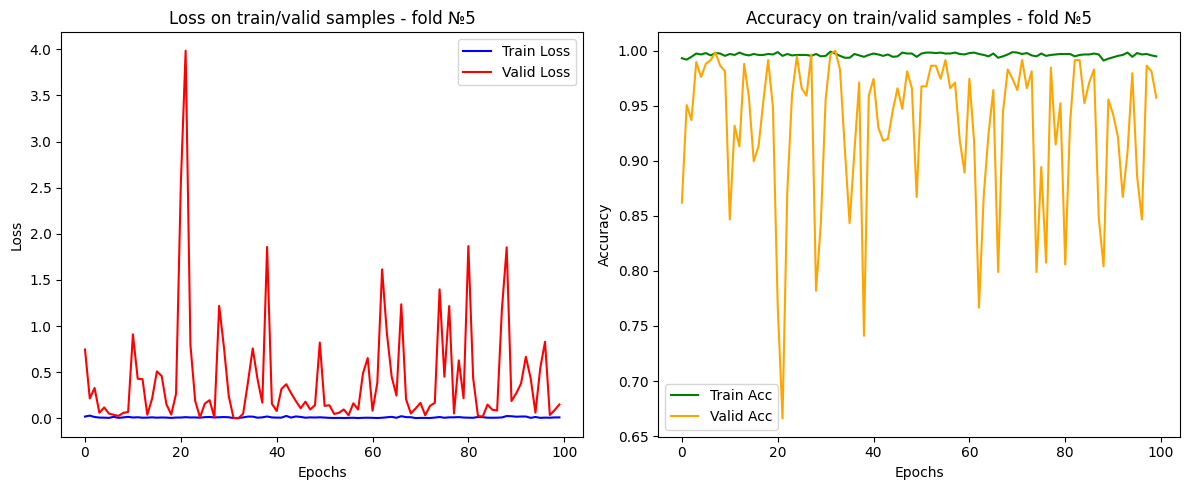

Accuracy fold 5: 0.9574

Average accuracy by folds: 0.88
Accuracy for all predictions (aggregated): 0.88


In [49]:
# Val generator for "test" prediction
X = np.array(train_generator.image_path)   # file paths
y = np.array(train_generator.labels)       # numeric class labels

Epochs = 100
batch_size = 64
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# for storing predictions and labels
all_y_true = []
all_y_pred = []
test_fold_predictions = []
fold_accuracies = []

def plot_loss(epochs, fold_number, fold_history):
    epochs_range = range(epochs)
    
    acc = fold_history.history['accuracy']
    loss = fold_history.history['loss']
    val_acc = fold_history.history['val_accuracy']
    val_loss = fold_history.history['val_loss']
    
    plt.figure(figsize=(12, 5))
    
    # ---- Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss,     label='Train Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Valid Loss', color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss on train/valid samples - fold №{fold_number + 1}")

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc,     label='Train Acc', color='green')
    plt.plot(epochs_range, val_acc, label='Valid Acc', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy on train/valid samples - fold №{fold_number + 1}")

    plt.tight_layout()
    plt.show()


for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
    
    train_gen = CustomDataGenerator(directory = train_dir,
                                    batch_size = batch_size,
                                    image_shape = (150, 150),
                                    augment = True,
                                    crossvalid_index = idx_train,
                                    shuffle=True)

    valid_gen = CustomDataGenerator(directory = train_dir,
                                    batch_size = batch_size,
                                    image_shape = (150, 150),
                                    augment = False,
                                    crossvalid_index = idx_valid,
                                    shuffle = False)

    print(f"Fold - №{fold + 1}...")

    history = model.fit(train_gen,
                        steps_per_epoch = len(train_gen),
                        epochs = Epochs,
                        validation_data = valid_gen,
                        validation_steps = len(valid_gen),
                        verbose = 0
                       )

    plot_loss(Epochs, fold, history)

    # ---------- PREDICT ON VALID SET ----------
    y_prob = model.predict(valid_gen, verbose=0)   # probabilities
    y_pred = np.argmax(y_prob, axis=1)             # predicted class indices

    # ---------- TRUE LABELS ----------
    y_true = np.concatenate([batch_y for _, batch_y in valid_gen])

    # save all
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    # Accuracy for the current fold
    acc = accuracy_score(y_true, y_pred)
    fold_accuracies.append(acc)
    print(f"Accuracy fold {fold+1}: {acc:.4f}")

# ---------- SUMMARY METRICS ----------
overall_acc = accuracy_score(all_y_true, all_y_pred)
print("\n============================")
print(f"Average accuracy by folds: {np.mean(fold_accuracies):.2f}")
print(f"Accuracy for all predictions (aggregated): {overall_acc:.2f}")

                                                        Final results on cross-validation

| Method                 | Average accuracy by folds   | Count of folds | Validation method | Accuracy on test data (val_generator) |
| -----------------------| --------------------------- | ---------------| ----------------- | ------------------------------------- |
| `Custom generator`     | `0.94`                      | 5              | KFold             | `0.XX`                                |
| `ImageDataGenerator`   | `0.88`                      | 5              | KFold             | `0.XX`                                |

You can use the forecast based on the test data by inserting this code cell.:
- Before validation:
```python
test_fold_predictions = []
```
- Into the validation cycle:
```python
# ----------- PREDICT ON TEST SET -----------
test_gen = CustomDataGenerator(directory = val_dir,
                               batch_size = batch_size,
                               image_shape = (150, 150),
                               augment = False,
                               shuffle = False)
y_prob_test_fold = model.predict(test_gen, verbose = 0)
test_fold_predictions.append(y_prob_test_fold)
```
- After the validation cycle:
```python
# ---------- AVERAGE TEST PREDICTIONS ----------
y_prob_test_avg = np.mean(test_fold_predictions, axis = 0)
y_pred_test     = np.argmax(y_prob_test_avg, axis = 1)
y_true_test     = np.concatenate([batch_y for _, batch_y in test_gen])
test_acc = accuracy_score(y_true_test, y_pred_test)
print(f"\nFinal averaged test accuracy across folds: {test_acc:.2f}")
```

# 3 method. This is the training of our ImageDataGenerator.

Previously (keras<2.1), when you wanted to train a model on a data generator (ImageDataGenerator.flow(...)), you had to call fit_generator.

If the data was numpy arrays, fit was used.

Starting with TensorFlow 2.1+, developers have combined both approaches.:

Now fit can work with both numpy and generators (Sequence, tf.data, ImageDataGenerator, etc.).

Therefore, fit_generator is considered obsolete and in new versions of TensorFlow/Keras it simply calls a wrapper over fit.

| Method                  | When used                                                       | Now                                                      |
| ----------------------- | --------------------------------------------------------------- | ---------------------------------------------------------|
| ` model.fit()`          | Training on `numpy` arrays                                      | Universal method (and numpy, and generators, and tf.data)|
| `model.fit_generator()` | Training on generators (`ImageDataGenerator.flow`, `Sequence`)  | Deprecated, replaced by `fit`                            |

In [131]:
train_image_gen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_data_gen = train_image_gen.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (image_shape, image_shape),
                                                     class_mode = 'sparse')

val_image_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen  = val_image_gen.flow_from_directory(batch_size = batch_size,
                                                  directory = val_dir,
                                                  target_size = (image_shape, image_shape),
                                                  class_mode = 'sparse')

history = model.fit_generator(train_data_gen,
                              steps_per_epoch = int(np.ceil(train_data_gen.samples / float(batch_size))),
                              epochs = Epochs,
                              validation_data = val_data_gen,
                              validation_steps = int(np.ceil(val_data_gen.samples / float(batch_size))))

Epoch 1/100
31/31 [==============================] - 27s 788ms/step - loss: 1.4382 - accuracy: 0.3748 - val_loss: 1.1310 - val_accuracy: 0.5619
Epoch 2/100
31/31 [==============================] - 22s 720ms/step - loss: 1.1305 - accuracy: 0.5300 - val_loss: 1.0409 - val_accuracy: 0.5864
Epoch 3/100
31/31 [==============================] - 22s 713ms/step - loss: 1.0143 - accuracy: 0.5898 - val_loss: 0.9623 - val_accuracy: 0.6122
Epoch 4/100
31/31 [==============================] - 23s 736ms/step - loss: 0.9712 - accuracy: 0.5966 - val_loss: 0.9365 - val_accuracy: 0.6299
Epoch 5/100
31/31 [==============================] - 23s 734ms/step - loss: 0.9068 - accuracy: 0.6385 - val_loss: 0.8804 - val_accuracy: 0.6408
Epoch 6/100
31/31 [==============================] - 23s 751ms/step - loss: 0.8625 - accuracy: 0.6548 - val_loss: 0.7762 - val_accuracy: 0.7116
Epoch 7/100
31/31 [==============================] - 23s 730ms/step - loss: 0.8081 - accuracy: 0.6759 - val_loss: 0.7439 - val_accuracy:

Optionally, we display charts of the loss function and accuracy.

To control retraining, the output of these graphs is required. For example, below, on the loss function chart, we see that the model begins to retrain on the validation sample, the chart does not go down, but up, after about 50 epochs. For such cases, you can use transfer learning, add Dropout layers, regularization, take a different split into train/valid samples, simplify the structure of the neural network, add new data to the dataset, etc..

In [71]:
epochs_range = range(Epochs)

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

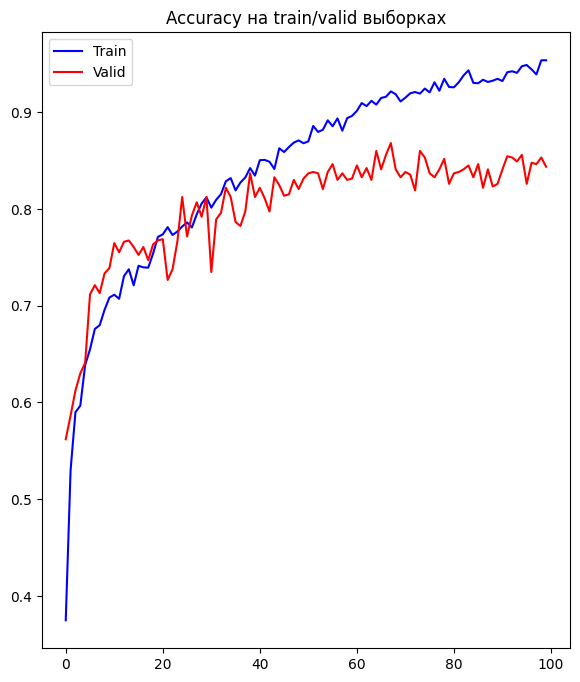

In [136]:
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Train', color = 'blue')
plt.plot(epochs_range, val_acc, label = 'Valid', color = 'red')
plt.legend()
plt.title("Accuracy on train/valid samples");

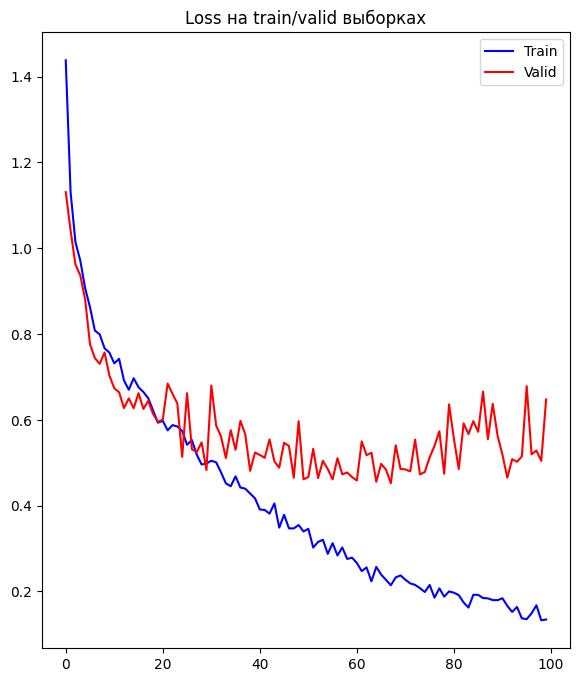

In [137]:
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Train', color = 'blue')
plt.plot(epochs_range, val_loss, label = 'Valid', color = 'red')
plt.legend()
plt.title("Loss on train/valid samples");